# Tensorflow tutorial: a simple logistic regression example

In this notebook, we will implement a simple logistic regression example using tensorflow. We will apply the basic concepts of tensorflow to implement logistic regression using gradient descent on the mnist dataset. The mnist handwritten digit recognition dataset is a very classical dataset. It presents no challenge today, and best known algorithms can reach an accuracy of 99+%. However, it can still be instructive as an example.

In [1]:
import tensorflow as tf
import numpy as np

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [40]:
# Let's import the data and have a look first

from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('../data/mnist', one_hot=True)

Extracting ../data/mnist\train-images-idx3-ubyte.gz
Extracting ../data/mnist\train-labels-idx1-ubyte.gz
Extracting ../data/mnist\t10k-images-idx3-ubyte.gz
Extracting ../data/mnist\t10k-labels-idx1-ubyte.gz


The mnist images are 28 x 28 grayscale images, and hence can be represented as vectors of length 784. Modern image algorithms work on much larger images, and usually 3 colour channels (rgb). The training dataset will thus often be represented as a 4-dimensional tensor (sample, height, width, channel), or (sample, channel, heigth, width). In this example, we will simply use the images as a long vector, and our dateset will thus be represented as a 2-dimensional tensor (sample, pixel).

(784,)


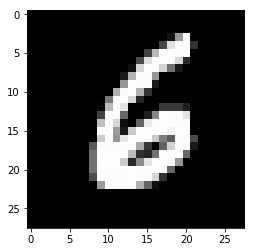

In [7]:
print(mnist.train.images[121].shape)
plt.imshow(mnist.train.images[121].reshape(28,28),cmap='gray')
plt.show()

## One-hot encoding

One-hot encoding is a commonly used form to encode the labels. It transform the label into a vector $(0, 0, \dotsc, 1, \dotsc, 0)$, where the $1$ is at the index corresponding to the label. In our case, this transforms the vector of labels into a matrix, with each row corresponding to a one-hot encoded label.

In [9]:
mnist.train.labels

array([[ 0.,  0.,  0., ...,  1.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  1.,  0.]])

## Logistic regression

We quickly recall multiclass logistic regression. In multiclass logistic regression, we output a linear predictor for each possible outcome class, and then compute the respective probabilities as the softmax. To obtain the estimator, we simply minimize the cross-entropy loss with the true data. We will use gradient descent to do so.

## Gradient descent in Tensorflow

One of the main features of tensorflow is the possibility to automatically compute gradients (by using the back-propagation rule you learned in class). This means that tensorflow can automate the implementation of gradient descent for us. We will be using an automatically provided gradient for this example.

In [24]:
# If you get errors everywhere, your graph has gone slightly haywire.
# Just run this cell to reset everything

tf.reset_default_graph()

In [25]:
# Define the model and the training setup

x = tf.placeholder(tf.float32, [None, 784]) # the image
y = tf.placeholder(tf.float32, [None, 10]) # the one-hot label

W = tf.get_variable('W', shape=[784, 10])
b = tf.get_variable('b', shape=[10])

logits = tf.add(tf.matmul(x, W), b, name='logits')
y_pred = tf.nn.softmax(logits, name='y_pred') # the predicted probability for each example.

# Compute the average cross-entropy across all the examples.
cross_entropy = tf.reduce_mean(-tf.reduce_sum(y * tf.log(y_pred), axis=[1]))

opt = tf.train.GradientDescentOptimizer(learning_rate=0.5)
train_step = opt.minimize(cross_entropy)        

In [26]:
# Define some operations to measure accuracy

prediction = tf.argmax(logits, 1, name='pred_class')
true_label = tf.argmax(y, 1, name='true_class')
accuracy = tf.reduce_mean(tf.cast(tf.equal(prediction, true_label), tf.float32))

In [27]:
# Let's run it!

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    for i in range(1000):
        _, ac = sess.run((train_step, accuracy), feed_dict={x: mnist.train.images[:5000,:], y: mnist.train.labels[:5000, :]})
        
        if i % 100 == 0:
            print('Step {0}: accuracy is {1}'.format(i + 1, ac))
    
    ac = sess.run(accuracy, feed_dict={x: mnist.test.images, y: mnist.test.labels})
    print('Accuracy on test set: {0}'.format(ac))

Step 1: accuracy is 0.08940000087022781
Step 101: accuracy is 0.9077997207641602
Step 201: accuracy is 0.9185997247695923
Step 301: accuracy is 0.9275997877120972
Step 401: accuracy is 0.9337997436523438
Step 501: accuracy is 0.9365997910499573
Step 601: accuracy is 0.9395997524261475
Step 701: accuracy is 0.9433997273445129
Step 801: accuracy is 0.9463996887207031
Step 901: accuracy is 0.9475997090339661
Accuracy on test set: 0.9052000045776367


## Doing it better: tensorflow code tips

Although the code above is perfectly functional, it has numerous issues in terms of maintanability, and is very prone to errors (for example, we can only run the cell once). Below, we explore some tensorflow features and code guidelines to make tensorflow code more reliable.

In [ ]:
# It is often advantageous to define the model parts in a function
# This makes them reusable. More complex models will often be composed
# of similar parts stuck together.

def compute_logits(x):
    """Compute the logits of the model"""
    W = tf.get_variable('W', shape=[784, 10])
    b = tf.get_variable('b', shape=[10])
    
    logits = tf.add(tf.matmul(x, W), b, name='logits')
    return logits

# Note: this function is implemented in tensorflow as
# tf.nn.softmax_cross_entropy_with_logits

# We have included it here for illustration only, please don't use it.
def compute_cross_entropy(logits, y):
    y_pred = tf.nn.softmax(logits, name='y_pred') # the predicted probability for each example.

    # Compute the average cross-entropy across all the examples.
    cross_entropy = tf.reduce_mean(-tf.reduce_sum(y * tf.log(y_pred), axis=[1]))
    return cross_entropy

def compute_accuracy(logits, y):
    prediction = tf.argmax(logits, 1, name='pred_class')
    true_label = tf.argmax(y, 1, name='true_class')
    accuracy = tf.reduce_mean(tf.cast(tf.equal(prediction, true_label), tf.float32))
    return accuracy

In [45]:
# We can also define our training loop as a separate function.

def train_model(train_step, accuracy, inputs):
    x, y = inputs
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
    
        for i in range(1000):
            _, ac = sess.run((train_step, accuracy), feed_dict={x: mnist.train.images[:5000,:], y: mnist.train.labels[:5000, :]})

            if i % 100 == 0:
                print('Step {0}: accuracy is {1}'.format(i + 1, ac))

        ac = sess.run(accuracy, feed_dict={x: mnist.test.images, y: mnist.test.labels})
        print('Accuracy on test set: {0}'.format(ac))

In [46]:
# As we mentioned in the introduction tutorial, it is better
# to be explicit about the default graph

# We put everything together in here.
import time

t_begin = time.perf_counter()

with tf.Graph().as_default():
    x = tf.placeholder(tf.float32, [None, 784], name='x')
    y = tf.placeholder(tf.float32, [None, 10], name='y')
    
    logits = compute_logits(x)
    loss = compute_cross_entropy(logits, y)
    accuracy = compute_accuracy(logits, y)
    
    opt = tf.train.GradientDescentOptimizer(0.5)
    train_step = opt.minimize(loss)
    
    train_model(train_step, accuracy, (x, y))

t_end = time.perf_counter()
print('Done in {0} seconds'.format(t_end - t_begin))

Step 1: accuracy is 0.12759998440742493
Step 101: accuracy is 0.8617997169494629
Step 201: accuracy is 0.9401997327804565
Step 301: accuracy is 0.9455996751785278
Step 401: accuracy is 0.9555997848510742
Step 501: accuracy is 0.9695996642112732
Step 601: accuracy is 0.9681997299194336
Step 701: accuracy is 0.9745997786521912
Step 801: accuracy is 0.9757997393608093
Step 901: accuracy is 0.9719997644424438
Accuracy on test set: 0.8773000240325928
Done in 17.55894879448323 seconds
